# Временные ряды. Разные взгляды на одно и то же

В данном jupyter notebook мы начнем погружение в мир автоматического машинного обучения для задач на временных рядах.

Однако чтобы хорошо разобраться в автоматическом инструментарии, сначала мы рассмотрим три парадигмы (подхода) в соответсвии с которыми разрабатываются AutoML подходы к обработке временных рядов.
Это не классификация (по крайней мере не настоящая), а скорее слабо очерченное шахматное поле котороые мы будем постепенно заполнять подходами. Это не является классификацией еще и потому что границы между парадигмами размыты и одна не исключает другую. Поэтому смотрите на предоставленный в данной тетрадке материал как авторское видение темы обработки временных рядов **в контексте AutoML**.

Но все начинается с данных. 

И поэтому, обращайте внимание на: 
- то как (с помощью какого кода) синтезируются временные ряды
- то как такие ряды выглядят и какими свойствами обладают

не обращайте внимание на: 
- тот код который помогает отрисовывать графики и анимации

## Определение 

Временной ряд — это набор наблюдений, упорядоченных во времени

Так давайте посмотрим на то какие они бывают!

<img src="../data/all_simple_synthetic_dataset_for_learning.png" alt="Time series dataset" width="500">



In [1]:
import numpy as np
import pandas  as pd
from pathlib import Path

import matplotlib.pyplot as plt

np.random.seed(42)

Поскольку, это набор, упорядоченных по времени, сгенерируем временную шкалу на 100 обьектов

In [2]:
start: str = "2025-01-01"
freq: str = "D"
n: int = 100

datetime_index = pd.date_range(start=start, periods=n, freq=freq)

А теперь сгенерируем временной ряд где каждый последующий элемент случаен

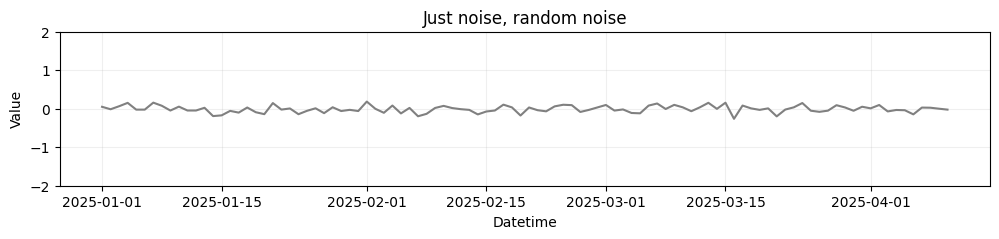

In [3]:
noise_component_max = 0.1
noise_values = np.random.normal(0, noise_component_max, n)

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, noise_values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Just noise, random noise")
plt.show()

Такой "временной ряд" состоит из шума и только 

Но есть и более интересные варианты.

## 1. Статистико-модельная парадигма

В рамках этого взгляда на временной ряд мы оперируем статистиками и смотрим на то как они изменеяются со временем.

И потому сначала поговорим про стационарность 

### Сезонность

> Сезонная компонента во временном ряду - это часть изменений,
которая повторяется с постоянной периодичностью во времени
(например, раз в сутки, раз в неделю, раз в год)

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

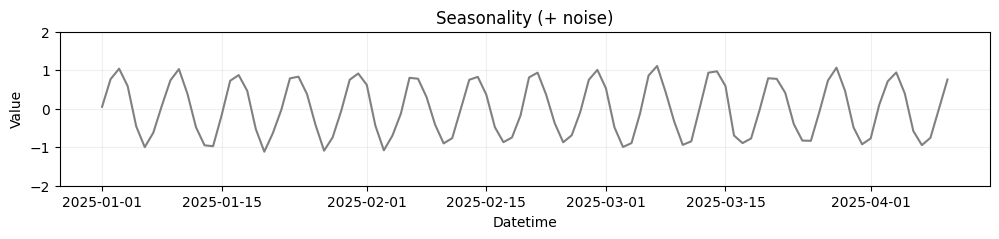

In [4]:
t = np.arange(n)
# Let's simulate week seasonality
m = 7
values = np.sin(2 * np.pi * t / m) + noise_values

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Seasonality (+ noise)")
plt.show()

### Циклы

> Циклическая компонента (или циклы) во временном ряду -
это часть колебаний, отражающая долгосрочные волнообразные изменения вокруг тренда,
которые не имеют фиксированной длины периода

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016).
Time Series Analysis: Forecasting and Control (5th ed.).
Wiley. глава 2.3 “The Components of a Time Series”, стр. 37–39.

© Chatfield, C. (2003). The Analysis of Time Series: An Introduction (6th ed.).
Chapman & Hall/CRC, глава 1.3 “Trend, Seasonal and Cyclical Variation”.

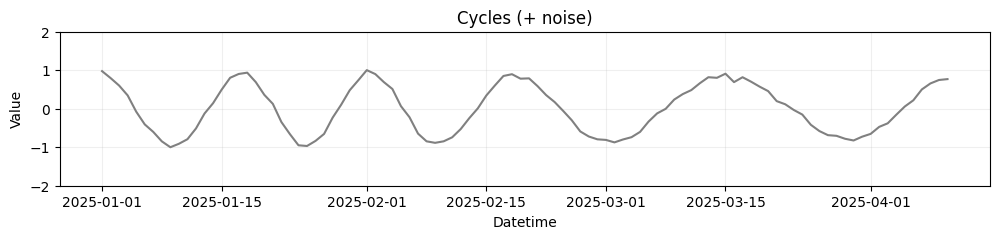

In [5]:
# Generating cycles
freq_base = 1 / 20
freq_variation = 1 / 60 * np.sin(2 * np.pi * t / n)
instantaneous_freq = freq_base + freq_variation
phase = 2 * np.pi * np.cumsum(instantaneous_freq)
values = np.cos(phase) * np.exp(-t / 400) + noise_values * 0.5

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Cycles (+ noise)")
plt.show()

### Тренд

> Тренд во временном ряду - это долгосрочная, устойчиво направленная компонента,
отражающая общую тенденцию изменения уровня ряда во времени
(например, рост, спад или стабильность),
не зависящую от краткосрочных колебаний и случайных флуктуаций.

© Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2016). Time Series Analysis: Forecasting and Control (5th ed.). Wiley. глава 2.3 "The Components of a Time Series", стр. 36–38

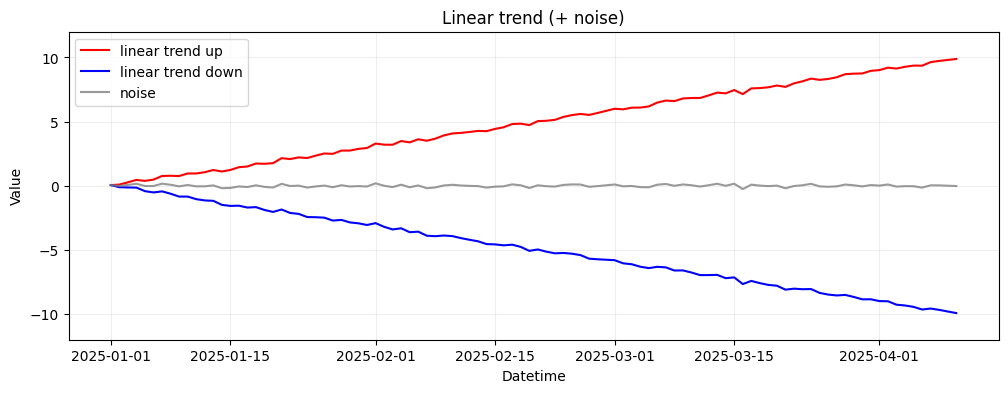

In [6]:
values_up = 0.1 * t + noise_values
values_down = -0.1 * t + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values_up, c="red", label="linear trend up")
ax.plot(datetime_index, values_down, c="blue", label="linear trend down")
ax.plot(datetime_index, noise_values, c="grey", alpha=0.8, label="noise")
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Linear trend (+ noise)")
plt.show()

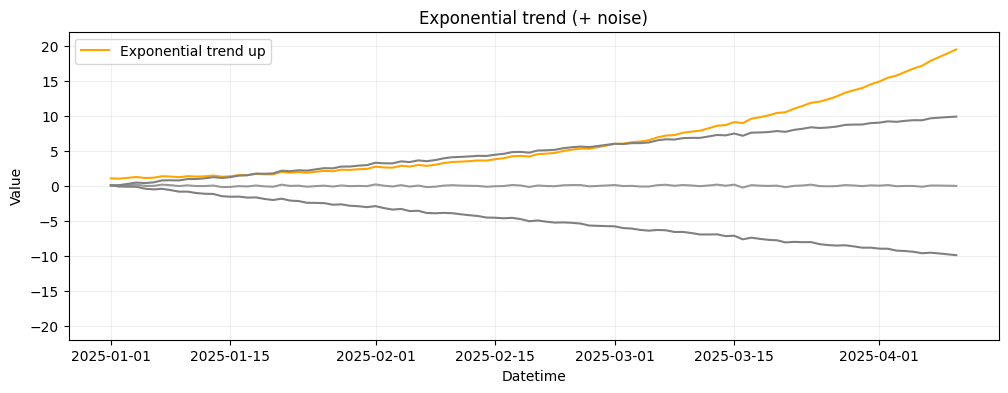

In [7]:
values = np.exp(0.03 * t) + noise_values

fig_size = (12.0, 4.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="orange", label="Exponential trend up")
ax.plot(datetime_index, values_up, c="grey")
ax.plot(datetime_index, values_down, c="grey")
ax.plot(datetime_index, noise_values, c="grey", alpha=0.8)
ax.grid(alpha=0.2)
ax.legend()
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-22, 22)
ax.set_title("Exponential trend (+ noise)")
plt.show()

### Переключения режима (структурные сдвиги)*

*эта категория может быть частным случаем тренда, сезонности или других нестационарностей во временном ряду.

> Структурный сдвиг во временном ряду —
это внезапное изменение статистических свойств ряда
(например, среднего уровня, дисперсии или характера зависимости между наблюдениями),
происходящее в определённый момент времени
вследствие изменения внешних условий или внутренних характеристик исследуемого процесса.

© Gujarati, D. N., & Porter, D. C. (2009).
Basic Econometrics (5th ed.). McGraw-Hill, глава 12:
Structural Change and Dummy Variables.

© Hamilton, J. D. (1994). Time Series Analysis. Princeton University Press — раздел 22.1 Structural Breaks.

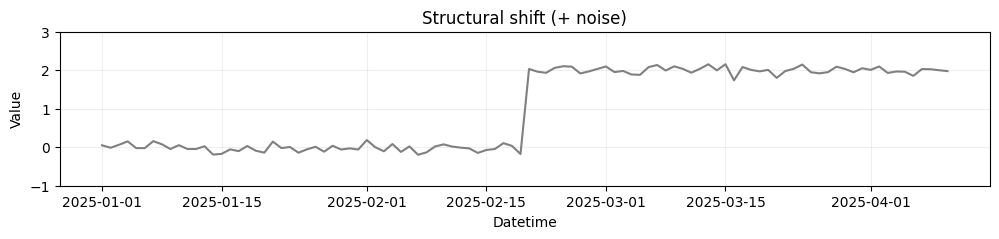

In [8]:
shift_point = n // 2
values = noise_values.copy()
values[shift_point:] += 2.0

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 3)
ax.set_title("Structural shift (+ noise)")
plt.show()

### Изменение в дисперсии

Изменение дисперсии (change in variance) означает, что разброс значений временного ряда во времени непостоянен

*Если вдруг ~никогда не знали~ забыли что такое дисперсия

> Дисперсия — это числовая характеристика случайной величины, показывающая, насколько сильно значения отклоняются от своего среднего.

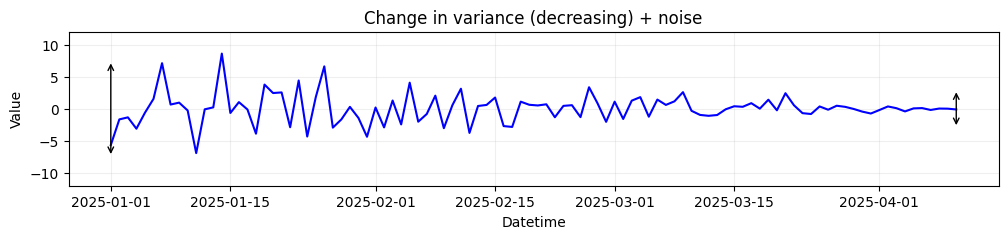

In [9]:
eps = np.random.normal(0, 2, n)
std_schedule = np.linspace(20, 0.5, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-12, 12)
ax.set_title("Change in variance (decreasing) + noise")
x_left = datetime_index[0]
ax.annotate('', xy=(x_left, 7.5), xytext=(x_left, -7.5), arrowprops=dict(arrowstyle='<->', color='black', lw=1))
x_right = datetime_index[-1]
ax.annotate('', xy=(x_right, 3), xytext=(x_right, -3),  arrowprops=dict(arrowstyle='<->', color='black', lw=1))
plt.show()

In [10]:
first_10 = values[:10]
last_10 = values[-10:]

var_first = np.var(first_10)
var_last = np.var(last_10)

print(f"Variance (first 10): {var_first:.2f}")
print(f"Variance (last 10):  {var_last:.2f}")

Variance (first 10): 10.03
Variance (last 10):  0.04


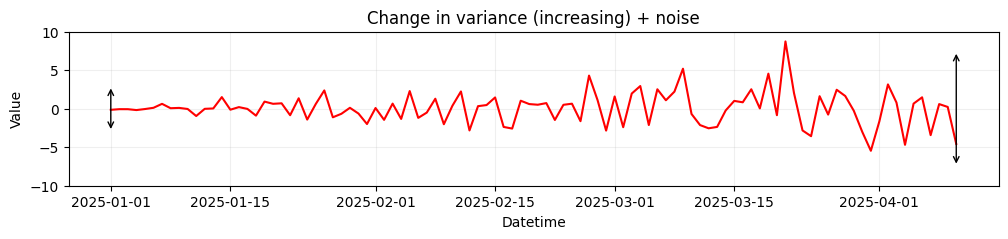

In [11]:
std_schedule = np.linspace(0.5, 20, n)
values = (0.1 * std_schedule) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-10, 10)
ax.set_title("Change in variance (increasing) + noise")
x_left = datetime_index[0]
ax.annotate('', xy=(x_left, 3), xytext=(x_left, -3), arrowprops=dict(arrowstyle='<->', color='black', lw=1))
x_right = datetime_index[-1]
ax.annotate('', xy=(x_right, 7.5), xytext=(x_right, -7.5),  arrowprops=dict(arrowstyle='<->', color='black', lw=1))
plt.show()

### Обьединение компонент

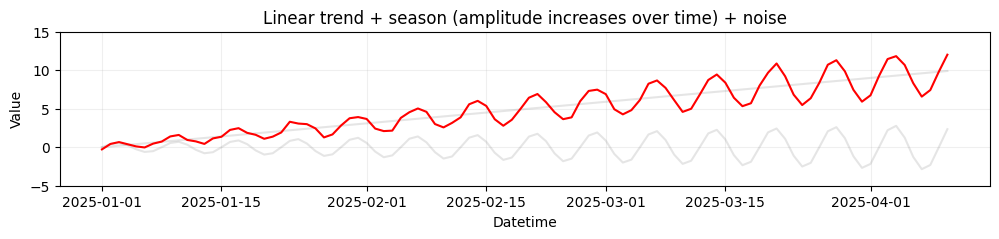

In [12]:
trend = 0.1 * t
# Amplitude of seasonal component increases over time
amplitude = np.linspace(0.5, 3.0, n)
seasonal = amplitude * np.sin(2 * np.pi * t / m)
values = trend + seasonal + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, trend, c="grey", alpha=0.2)
ax.plot(datetime_index, seasonal, c="grey", alpha=0.2)
ax.plot(datetime_index, values, c="red")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-5, 15)
ax.set_title("Linear trend + season (amplitude increases over time) + noise")
plt.show()

### Более сложные формы нестационарности

Продолжим с автокорреляцией

> Корреляция — это статистическая мера, показывающая, насколько и в каком направлении связаны две случайные величины.

> Автокорреляция — это корреляция ряда с самим собой, но со сдвигом (лагом) во времени.

Как рассчитывается Автокорреляция на примере предыдущего ряда

In [20]:
import ipywidgets as widgets
from ipywidgets import interact


def plot_lag_pairs(values, t, lag=3):
    n = len(values)
    lag = max(1, min(int(lag), n - 1))
    stride = 10

    cmap = plt.colormaps["coolwarm"]
    colors = [cmap(i / max(1, (n - lag))) for i in range(n - lag)]
    indices = [i for i in range(lag, n) if (i - lag) % stride == 0]

    table_data = pd.DataFrame({
        "t": [int(i) for i in indices],
        "y(t)": [values[i] for i in indices],
        f"y(t-{lag})": [values[i - lag] for i in indices]
    })

    fig = plt.figure(figsize=(15, 5))
    gs = fig.add_gridspec(1, 2, width_ratios=[3, 1])
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])

    ax1.plot(t, values, color="gray", lw=1.5, label="time series")
    ax1.scatter(t, values, color="gray", s=20, zorder=3)

    for i, color in zip(indices, [colors[i - lag] for i in indices]):
        ax1.plot([t[i - lag], t[i]], [values[i - lag], values[i]], color=color, lw=2, alpha=0.85)
        ax1.scatter([t[i - lag], t[i]], [values[i - lag], values[i]], color=color, s=50, zorder=3)
        ax1.text(t[i - lag], values[i - lag] + 0.3, f"{values[i - lag]:.2f}",
                 color=color, ha='center', va='bottom', fontsize=8, weight='bold')
        ax1.text(t[i], values[i] - 0.3, f"{values[i]:.2f}",
                 color=color, ha='center', va='top', fontsize=8, weight='bold')

    ax1.set_title(f"Autocorrelation illustration for lag={lag} (every {stride}th pair shown)", fontsize=13)
    ax1.set_xlabel("t")
    ax1.set_ylabel("y(t)")
    ax1.grid(alpha=0.2)

    ax2.axis("off")
    if len(table_data) > 0:
        table = ax2.table(
            cellText=np.round(table_data.values, 2),
            colLabels=table_data.columns,
            loc="center",
            cellLoc="center"
        )
        table.scale(1.2, 1.6)
        table.auto_set_font_size(False)
        table.set_fontsize(10)
    else:
        ax2.text(0.5, 0.5, "Нет пар для отображения", ha="center", va="center")

    plt.tight_layout()
    plt.show()

interact(
    lambda lag: plot_lag_pairs(values, t, lag=lag),
    lag=widgets.IntSlider(value=3, min=1, max=max(2, len(values)-1), step=1, description="lag")
);

interactive(children=(IntSlider(value=3, description='lag', max=99, min=1), Output()), _dom_classes=('widget-i…

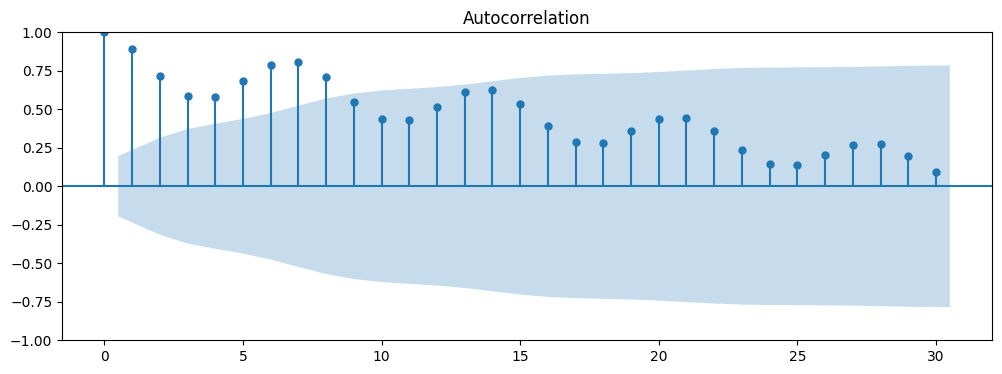

In [21]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(values, lags=30, ax=ax)
plt.show()

А теперь посмотрим на другой ряд

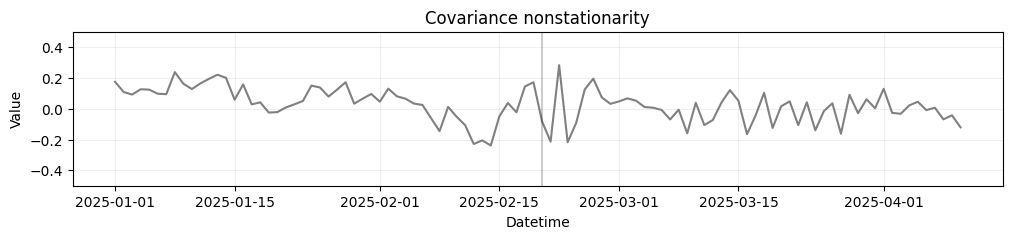

In [91]:
shift_point = n // 2
phi1, phi2 = 0.7, -0.3

# Choose innovation std so that the unconditional variance remains base_sigma^2
# For AR(1): Var(y) = sigma_e^2 / (1 - phi^2) => sigma_e = base_sigma * sqrt(1 - phi^2)
sigma_e1 = 0.1 * np.sqrt(1.0 - phi1 ** 2)
sigma_e2 = 0.1 * np.sqrt(1.0 - phi2 ** 2)

e1 = np.random.normal(0, sigma_e1, shift_point)
e2 = np.random.normal(0, sigma_e2, n - shift_point)

values = np.zeros(n)
values[0] = np.random.normal(0, 0.1)

# First regime
for i in range(1, shift_point):
    values[i] = phi1 * values[i - 1] + e1[i]

# Second regime
for i in range(shift_point, n):
    prev = values[i - 1] if i > 0 else 0.0
    values[i] = phi2 * prev + e2[i - shift_point]

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values, c="grey")
ax.grid(alpha=0.2)
ax.axvline(datetime_index[shift_point], c='black', alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-0.5, 0.5)
ax.set_title("Covariance nonstationarity")
plt.show()

И рисуем по нему график автокорреляции

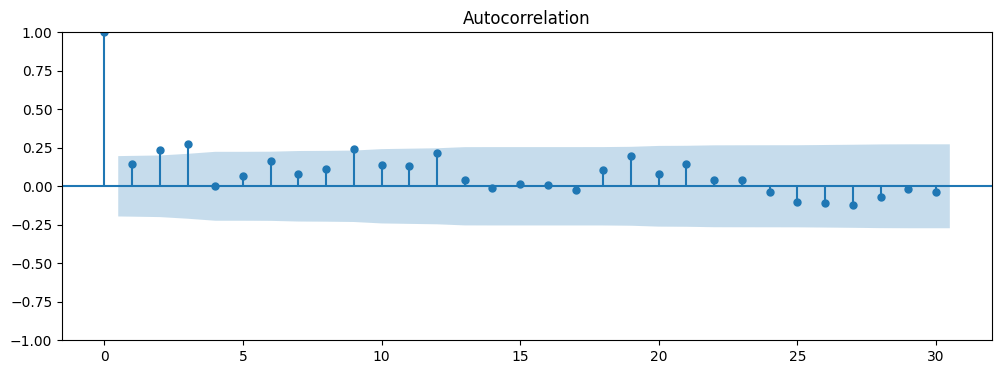

In [80]:
fig, ax = plt.subplots(figsize=(12, 4))
plot_acf(values, lags=30, ax=ax)
plt.show()

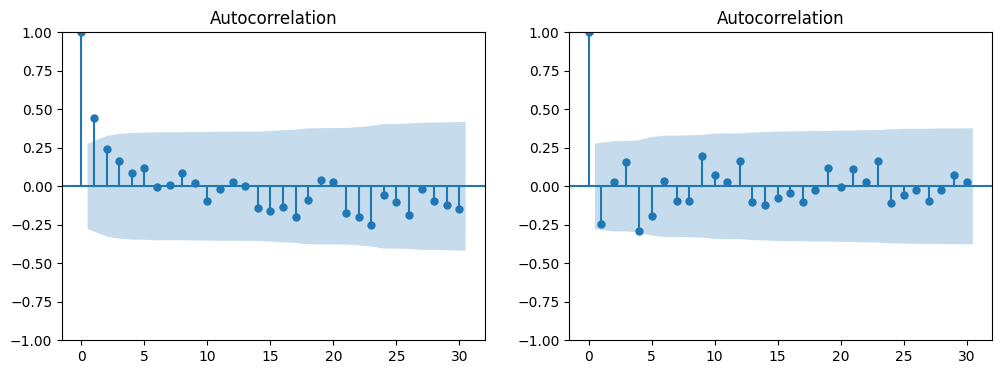

In [85]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
plot_acf(values[:shift_point], lags=30, ax=axs[0])
plot_acf(values[-shift_point:], lags=30, ax=axs[-1])
plt.show()

### Неочевидное разделение

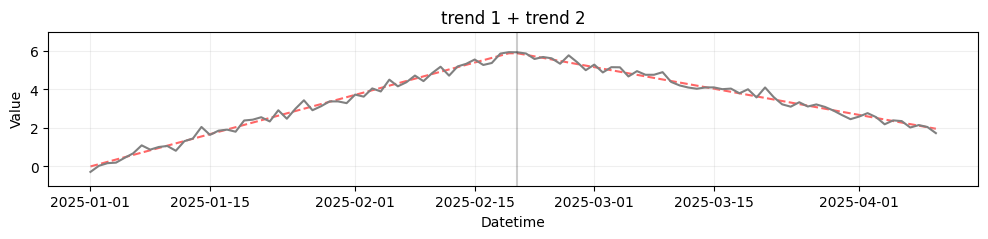

In [29]:
shift_point = n // 2
slope1, slope2 = 0.12, -0.08  # tweak as needed
trend = np.empty(n, dtype=float)
trend[:shift_point] = slope1 * np.arange(shift_point)
# Continue from the last level to avoid jumps at the kink
base_level = trend[shift_point - 1]
trend[shift_point:] = base_level + slope2 * np.arange(n - shift_point)
values = trend + 0.1 * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, trend, '--', c="red", alpha=0.6, zorder=1)
ax.plot(datetime_index, values, c="grey", zorder=2)
ax.grid(alpha=0.2)
ax.axvline(datetime_index[50], c='black', alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-1, 7)
ax.set_title("trend 1 + trend 2")
plt.show()

TODO: может имеет смысл добавить здесь более длинный ряд когда видно что оба этих "тренда", это просто часть сезона

### Комбинация различных компонентов

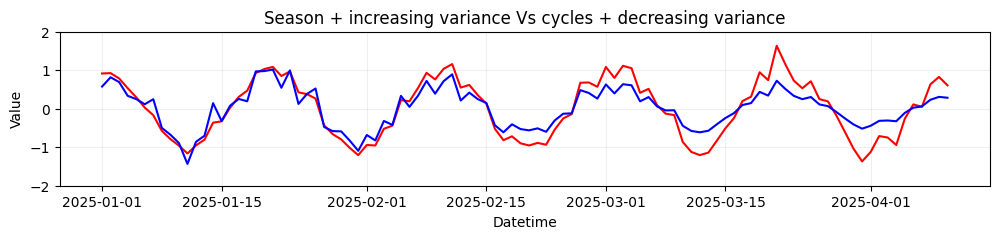

In [30]:
m_sync = 20  # common period for both series
phi = 0.0  # common phase
std_up = np.linspace(0.3, 1.5, n)  # increasing variance
seasonal = np.cos(2 * np.pi * t / m_sync + phi)  # SAME base wave as below
values_non_stationary_seasonal_var_increasing = seasonal + (0.1 * std_up) * eps

std_down = np.linspace(1.5, 0.3, n)  # decreasing variance
cycles = np.cos(2 * np.pi * t / m_sync + phi) * np.exp(-t / n)  # SAME wave + mild damping
values_stationary_cycles_var_decreasing = cycles + (0.1 * std_down) * eps

fig_size = (12.0, 2.0)
fig, ax = plt.subplots(figsize=fig_size)
ax.plot(datetime_index, values_non_stationary_seasonal_var_increasing, c="red")
ax.plot(datetime_index, values_stationary_cycles_var_decreasing, c="blue")
ax.grid(alpha=0.2)
ax.set_xlabel("Datetime")
ax.set_ylabel("Value")
ax.set_ylim(-2, 2)
ax.set_title("Season + increasing variance Vs cycles + decreasing variance")
plt.show()

### Попытаемся декомпозировать обратно

Сначала возьмем ряд попроще

TODO показать сначала ряд, а потом его разложение

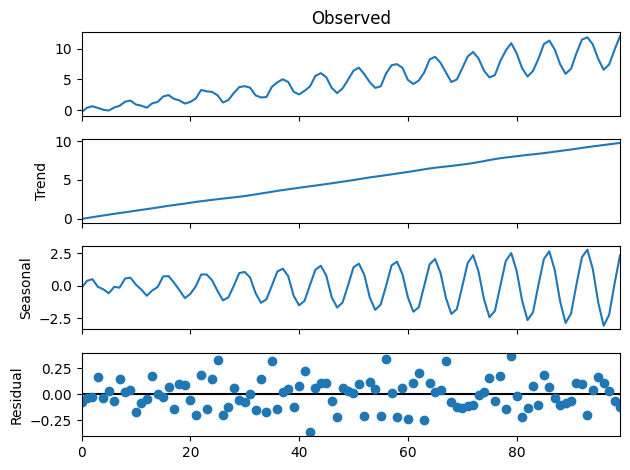

In [31]:
from statsmodels.tsa.seasonal import STL

trend = 0.1 * t
m = 7
amplitude = np.linspace(0.5, 3.0, n)
seasonal = amplitude * np.sin(2 * np.pi * t / m)
values = trend + seasonal + 0.1 * eps

res = STL(values, period=m).fit()
res.plot()
plt.show()

Теперь посложнее

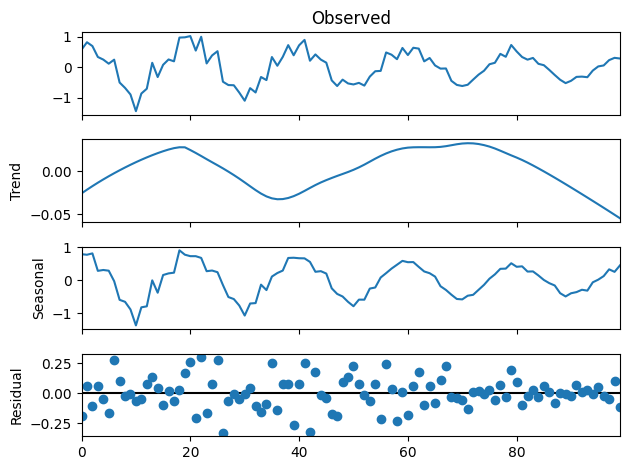

In [32]:
res = STL(values_stationary_cycles_var_decreasing, period=m_sync).fit()
res.plot()
plt.show()

## 2. Частотно-спектральная парадигма

Это мир гармоник, частот и волн

Вейвлет преобразование

## 3. Геометрическая (shape-based) парадигма

Shapelet, SAX

## Многомерные временные ряды